# importation data set

In [1]:
from flickr30k import Dataset
import matplotlib.pyplot as plt
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import clip
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm
import faiss

# Build the dataseta
builder = Dataset()
builder.download_and_prepare()

# Load the dataset
ds = builder.as_dataset()

dataset = ds["test"]

# Check example
# print(ds["test"][0])
print(dataset)

max_char_len = 200

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

c:\Users\cyril\anaconda3\envs\clip_flickr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
    num_rows: 31014
})


# extraction feature

In [8]:
image_embeddings = []
text_embeddings = []
image_paths = []
captions = []

for sample in tqdm(dataset):
    # print(sample)
    image_path = "flickr30k-images/"+sample['filename']
    caption_list = sample['caption']  # this is a list — pick one, or average later
    

    # Load and encode image
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embedding = model.encode_image(image)
    image_embedding = image_embedding.cpu().numpy()

    # embed le text
    caption_embeddings = []
    for caption in caption_list:
        text_token = clip.tokenize([caption[:max_char_len]]).to(device)
        with torch.no_grad():
            text_embedding = model.encode_text(text_token)
        text_embedding = text_embedding.cpu().numpy()
        caption_embeddings.append(text_embedding)

    # Average caption embeddings
    caption_embeddings = np.vstack(caption_embeddings)
    mean_caption_embedding = np.mean(caption_embeddings, axis=0, keepdims=True)

    image_embeddings.append(image_embedding)
    text_embeddings.append(mean_caption_embedding)
    image_paths.append(image_path)
    captions.append(caption_list)

image_embeddings = np.vstack(image_embeddings)
text_embeddings = np.vstack(text_embeddings)

#concatene pour faire le mutlimodal
image_embeddings_norm = image_embeddings / np.linalg.norm(image_embeddings, axis=1, keepdims=True)
text_embeddings_norm = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)
multimodal_embeddings = np.hstack([image_embeddings_norm, text_embeddings_norm])

# Save multimodal embeddings if needed
np.save("flickr30k_clip_multimodal_embeddings.npy", multimodal_embeddings)


#créate FAISS pour tout indexer
dimension = image_embeddings.shape[1]
image_index = faiss.IndexFlatL2(dimension)
image_index.add(image_embeddings.astype('float32'))

#stock tout
faiss.write_index(image_index, "flickr30k_clip_images.index")
np.save("image_paths.npy", image_paths)

#pariel pour text
text_index = faiss.IndexFlatL2(dimension)
text_index.add(text_embeddings.astype('float32'))

# Save text index
faiss.write_index(text_index, "flickr30k_clip_texts.index")
np.save("captions.npy", captions)


# Save multimodal index
multimodal_index = faiss.IndexFlatL2(multimodal_embeddings.shape[1])
multimodal_index.add(multimodal_embeddings.astype('float32'))
faiss.write_index(multimodal_index, "flickr30k_clip_multimodal.index")


100%|██████████| 31014/31014 [51:14<00:00, 10.09it/s] 


In [2]:
image_index = faiss.read_index("flickr30k_clip_images.index")
text_index = faiss.read_index("flickr30k_clip_texts.index")
multimodal_index = faiss.read_index("flickr30k_clip_multimodal.index")
image_paths = np.load("image_paths.npy", allow_pickle=True)
captions = np.load("captions.npy", allow_pickle=True)



# appelle

In [3]:


# def display_results(query_path, result_paths, captions, image_apth):
#     k = len(result_paths)

#     plt.figure(figsize=(3*(k+1), 4))

#     # Plot query image
#     plt.subplot(1, k+1, 1)
#     plt.imshow(Image.open(query_path))
#     plt.title("Query")
#     plt.axis("off")

#     # Plot retrieved images
#     for i, img_path in enumerate(result_paths):
#         plt.subplot(1, k+1, i+2)
#         plt.imshow(Image.open(img_path))
#         plt.title(f"Top {i+1}")
#         plt.axis("off")
    
#         idx = image_paths.tolist().index(img_path)
#         all_captions = captions[idx]
#         short_caption = all_captions[0]  # or "\n".join(all_captions[:2]) for 2-line
#         plt.xlabel(short_caption[:80] + ("..." if len(short_caption) > 80 else ""), fontsize=8)


#     plt.tight_layout()
#     plt.show()


def display_results(query_path, result_paths, captions, image_paths):
    k = len(result_paths)
    plt.figure(figsize=(4*(k+1), 5))

    # Plot query image
    plt.subplot(1, k+1, 1)
    plt.imshow(Image.open(query_path))
    plt.title("Query")
    plt.axis("off")

    # Plot retrieved images with captions
    for i, img_path in enumerate(result_paths):
        plt.subplot(1, k+1, i+2)
        plt.imshow(Image.open(img_path))
        plt.title(f"Top {i+1}")
        plt.axis("off")

        # Show caption below the image
        idx = image_paths.tolist().index(img_path)
        all_captions = captions[idx]
        short_caption = all_captions[0]  # or "\n".join(all_captions[:2]) for 2-line
        plt.xlabel(short_caption[:80] + ("..." if len(short_caption) > 80 else ""), fontsize=8)

    plt.tight_layout()
    plt.show()


#trouve quand sémantiquement c'est la même chose



In [4]:
print(image_paths[28408])

flickr30k-images/6827028.jpg


compute an image


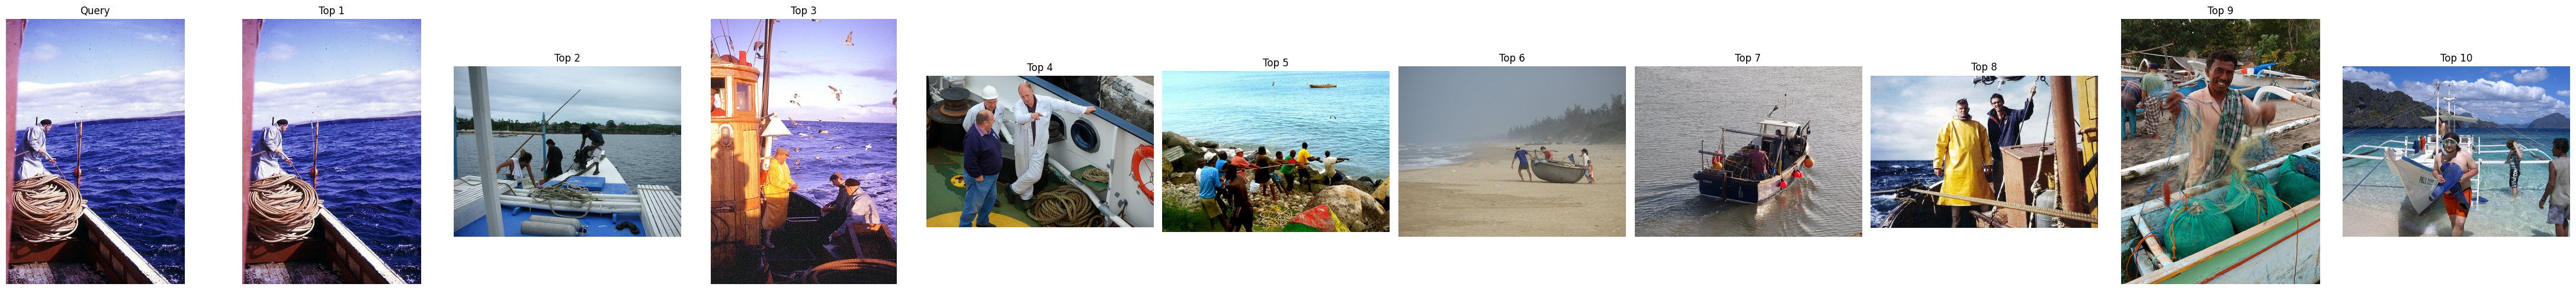

Retrieved indices: [28408, 15170, 29768, 24341, 15164, 16115, 26679, 26173, 932, 20839]
Relevant indices: [5553, 14555, 26337, 28406, 29315, 30145, np.int64(0)]
Precision: 0.000, Recall: 0.000, AP: 0.000


In [ ]:
top= 10


# Set the path to the query image and the query text
path_to_querry = "flickr30k-images/6827028.jpg"  # set your image path here
query_text = "Four runners"      # set your text query here

# Compute image embedding if image is provided
if path_to_querry:
    print("compute an image")
    query_image = preprocess(Image.open(path_to_querry)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embedding = model.encode_image(query_image).cpu().numpy()
else:
    image_embedding = None

# Compute text embedding if text is provided
if query_text:
    text_token = clip.tokenize([query_text[:max_char_len]]).to(device)
    with torch.no_grad():
        text_embedding = model.encode_text(text_token).cpu().numpy()
else:
    text_embedding = None

# Combine embeddings for multimodal search
if image_embedding is not None and text_embedding is not None:
    # Normalize and concatenate for multimodal
    embedding = np.hstack([
        image_embedding / np.linalg.norm(image_embedding),
        text_embedding / np.linalg.norm(text_embedding)
    ])
    # You need to have a multimodal index built with concatenated features for this to work
    # For now, let's just print a warning if no such index exists
    # Search using the multimodal index
    D, I = multimodal_index.search(embedding.astype('float32'), k=top)
elif image_embedding is not None:
    D, I = image_index.search(image_embedding.astype('float32'), k=top)
elif text_embedding is not None:
    D, I = text_index.search(text_embedding.astype('float32'), k=top)
else:
    raise ValueError("Please provide at least an image path or a text query.")

# Get paths of top images
top_image_paths = [image_paths[i] for i in I[0]]

# for i, img_path in enumerate(top_image_paths):
#     idx = image_paths.tolist().index(img_path)
#     img_captions = captions[idx]
#     print(f"Rank {i+1}:")
#     print(f"Image path: {img_path}")
#     print(f"Captions: {img_captions}")
#     print("-" * 40)

# Pass captions and image_paths to display_results for caption and image path display
display_results(path_to_querry if path_to_querry else top_image_paths[0], top_image_paths, captions, image_paths)

#fait match exact pour captions
query_words = set(query_text.lower().split())
relevant_indices = []

if query_text != "":
    for idx, img_captions in enumerate(captions):  # now a list of 5 strings
        for cap in img_captions:
            cap_words = set(cap.lower().split())
            if query_words.issubset(cap_words):
                relevant_indices.append(idx)
                break  # only need one matching caption to count the image as relevant
    

if image_embedding is not None:
    image_embedding_norm = image_embedding / np.linalg.norm(image_embedding)
    all_image_embeddings_norm = image_embeddings / np.linalg.norm(image_embeddings, axis=1, keepdims=True)

    # Compute cosine similarities
    similarities = all_image_embeddings_norm @ image_embedding_norm.T  # shape (N, 1)
    similarities = similarities.squeeze()  # shape (N,)

    # Define image-relevance by top-k similar images
    top_k_similar = 10  # can tune this value
    top_image_similar_indices = np.argsort(similarities)[-top_k_similar:][::-1]
    
    for idx in top_image_similar_indices:
        relevant_indices.append(idx)

retrieved_indices = [image_paths.tolist().index(p) for p in top_image_paths]

print(f"Retrieved indices: {retrieved_indices}")
print(f"Relevant indices: {relevant_indices}")

precision, recall, average_precision = compute_metrics(retrieved_indices, relevant_indices, k=top)
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, AP: {average_precision:.3f}")


In [7]:
k = 10  # number of top captions to retrieve

image_path = "flickr30k-images/6734417.jpg"  # set your image path here

# Compute image embedding from the given image path
query_image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
with torch.no_grad():
    image_embedding = model.encode_image(query_image).cpu().numpy()

# Search for the k nearest text embeddings to the given image_embedding
D, I = text_index.search(image_embedding.astype('float32'), k=k)
top_captions = [captions[idx] for idx in I[0]]

print("Top matching captions:")
for i, cap in enumerate(top_captions, 1):
    print(f"{i}. {cap}")



Top matching captions:
1. ["One young girl about six years old, with blond-hair wearing a lime green jacket, blue pants, and red rain boots, is tapping her foot in the lake and she doesn't even see the canoe in the distance by the trees without leaves."
 'A little blond girl in green parka and red rain boots is placing one foot at the edge of a small lake, with wintry trees and an occupied outboard motorboat in the background.'
 'A very young girl with a green coat and red rain boots putting her foot in the edge of a river, with the river and trees in the background.'
 'A child wearing yellow jacket stands on the shore testing the water with his red rubber boot clad toe.'
 'A cute little blond girl in red boots and a green jacket putting her foot in a pond.']
2. ['A small blond boy wearing a green coat, blue pants and white shoes is standing close to and looking at a body of water.'
 'A little blond boy wearing a green winter jacket at the beach excitingly looking at the water.'
 'A li

In [6]:
def compute_metrics(retrieved_indices, relevant_indices, k=None):
    
    if k is not None:
        retrieved_indices = retrieved_indices[:k]
    relevant_set = set(relevant_indices)
    retrieved_set = set(retrieved_indices)
    num_relevant = len(relevant_set)
    if num_relevant == 0:
        return 0.0, 0.0, 0.0

    # Precision and recall
    num_retrieved_relevant = len(retrieved_set & relevant_set)
    precision = num_retrieved_relevant / len(retrieved_indices)
    recall = num_retrieved_relevant / num_relevant

    # Average Precision (AP)
    hits = 0
    sum_precisions = 0.0
    for i, idx in enumerate(retrieved_indices):
        if idx in relevant_set:
            hits += 1
            sum_precisions += hits / (i + 1)
    average_precision = sum_precisions / num_relevant if num_relevant > 0 else 0.0

    return precision, recall, average_precision

def mean_average_precision(all_retrieved, all_relevant, k=None):
    ap_list = []
    for retrieved, relevant in zip(all_retrieved, all_relevant):
        _, _, ap = compute_metrics(retrieved, relevant, k)
        ap_list.append(ap)
    return np.mean(ap_list)